**Title:** TF-IDF Vectorization and Machine Learning Model

**Description:**

This Colab notebook implements a multi-label classification approach for extracting implicit features from restaurant reviews. The project includes the following main steps:

1. **Data Loading and Preprocessing:**
   - Load the dataset containing restaurant reviews and their corresponding implicit features.
   - Preprocess the text data, including lowercasing, punctuation and stopwords removal, tokenization, stemming, and lemmatization using NLTK.

2. **Feature Engineering:**
   - Apply TF-IDF vectorization to convert the text data into numerical features.
   - One-hot encode the implicit features.

3. **Model Training and Evaluation:**
   - Define logistic regression and SVM models for multi-label classification.
   - Split the data into training and testing sets.
   - Train and evaluate the models using the TF-IDF vectors and one-hot encoded implicit features.

4. **Metrics Evaluation:**
   - Evaluate the models using metrics such as ROC AUC, hamming loss, and F1-score for multi-label classification.

5. **Vectorizing Text Data:**
   - Utilize TF-IDF vectorization to convert the text data into numerical features.

6. **Training and Evaluation Functions:**
   - Define functions for training and evaluating the models.




# 1. Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, hamming_loss, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from wordcloud import WordCloud
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# 2. Load and Explore the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('Restaurants_Train.csv', encoding='utf-8')

In [3]:
# Display the first few rows of the dataset
print("First few rows of the dataset:")
df[:3]

First few rows of the dataset:


,text,aspectTerms/aspectTerm/0/_term,aspectTerms/aspectTerm/0/_polarity,aspectTerms/aspectTerm/0/_from,aspectTerms/aspectTerm/0/_to,aspectCategories/aspectCategory/0/_category,aspectCategories/aspectCategory/0/_polarity,_id,aspectCategories/aspectCategory/1/_category,aspectCategories/aspectCategory/1/_polarity,...,aspectTerms/aspectTerm/7/_term,aspectTerms/aspectTerm/7/_polarity,aspectTerms/aspectTerm/7/_from,aspectTerms/aspectTerm/7/_to,aspectCategories/aspectCategory/3/_category,aspectCategories/aspectCategory/3/_polarity,aspectTerms/aspectTerm/8/_term,aspectTerms/aspectTerm/8/_polarity,aspectTerms/aspectTerm/8/_from,aspectTerms/aspectTerm/8/_to
0,But the staff was so horrible to us.,staff,negative,8.0,13.0,service,negative,3121,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"To be completely fair, the only redeeming fact...",food,positive,57.0,61.0,food,positive,2777,anecdotes/miscellaneous,negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"The food is uniformly exceptional, with a very...",food,positive,4.0,8.0,food,positive,1634,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Display unique values in relevant columns
print("\nUnique values in 'Implicit Feature' column:")
print(df['aspectCategories/aspectCategory/0/_category'].unique())
# Check the distribution of categories
print("\nDistribution of categories:")
print(df['aspectCategories/aspectCategory/0/_category'].value_counts())


Unique values in 'Implicit Feature' column:
['service' 'food' 'anecdotes/miscellaneous' 'ambience' 'price']

Distribution of categories:
aspectCategories/aspectCategory/0/_category
food                       1158
anecdotes/miscellaneous    1082
service                     410
ambience                    261
price                       133
Name: count, dtype: int64


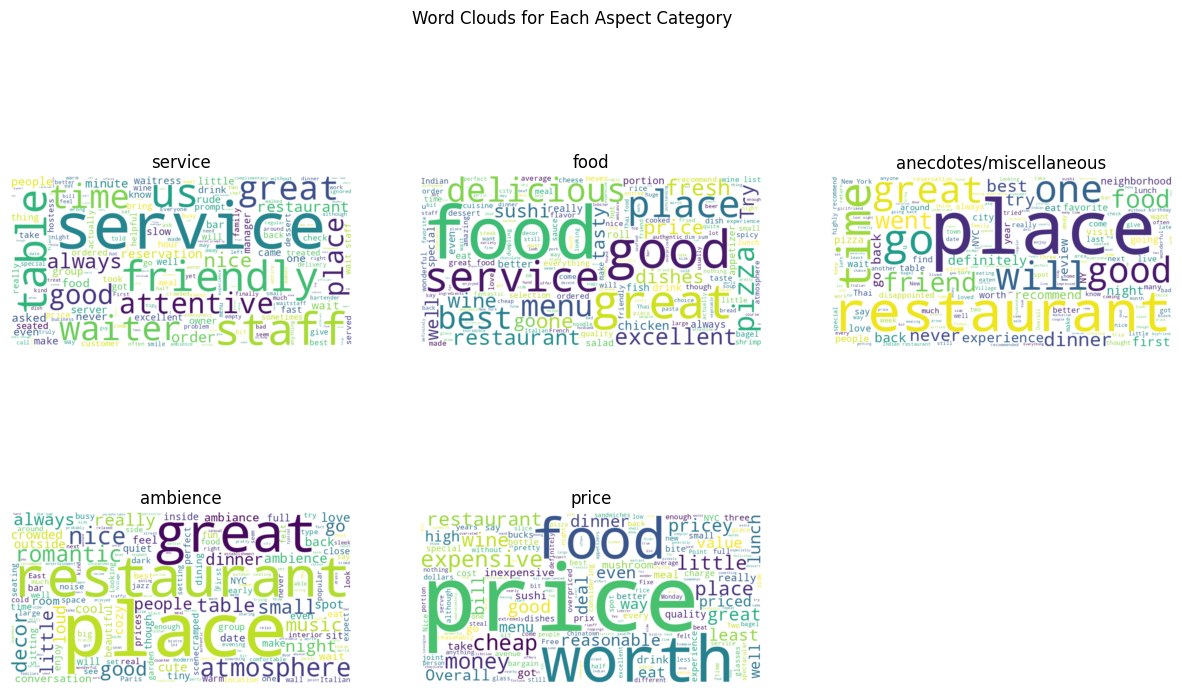

In [5]:
# Generate word clouds for each aspect category
plt.figure(figsize=(15, 8))
for category in df['aspectCategories/aspectCategory/0/_category'].unique():
    subset = df[df['aspectCategories/aspectCategory/0/_category'] == category]
    text = ' '.join(subset['text'])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.subplot(2, 3, list(df['aspectCategories/aspectCategory/0/_category'].unique()).index(category) + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(category)
    plt.axis('off')

plt.suptitle('Word Clouds for Each Aspect Category', y=1.02)
plt.show()


**The goal is to create a new DataFrame (df_csv) by extracting and organizing information from an existing DataFrame (df).**

The new DataFrame is structured to include columns as bellow:



1.  sentence
2.  implicit features

In [6]:
# Define the columns for the new DataFrame
dfcols = ['Sentence', 'Implicit Feature']
dataframe_list = []

# Loop through each row in the original DataFrame
for i, row in df.iterrows():
    category_list = []

    # Loop through each aspect category
    for j in range(4):  # 5 categories
        category = row['aspectCategories/aspectCategory/' + str(j) + '/_category']
        if pd.notna(category):
            category_list.append(category)

    # Append the processed row to the list
    dataframe_list.append([row['text'], category_list])

# Create a new DataFrame
df_csv = pd.DataFrame(dataframe_list, columns=dfcols)



In [7]:
df.head(3)
aspect_category_columns = ['text',
                            'aspectCategories/aspectCategory/0/_category',
                            'aspectCategories/aspectCategory/1/_category',
                            'aspectCategories/aspectCategory/2/_category',
                            'aspectCategories/aspectCategory/3/_category']

df_aspect_categories = df[aspect_category_columns]

In [8]:
df_aspect_categories.text[1]

"To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora."

In [9]:
df_csv['Implicit Feature'][2]

['food']

In [10]:
# new dataframe
df_csv.head()

,Sentence,Implicit Feature
0,But the staff was so horrible to us.,[service]
1,"To be completely fair, the only redeeming fact...","[food, anecdotes/miscellaneous]"
2,"The food is uniformly exceptional, with a very...",[food]
3,Where Gabriela personaly greets you and recomm...,[service]
4,"For those that go once and don't enjoy it, all...",[anecdotes/miscellaneous]


In [11]:
# Check the data types and non-null counts for each column
print("\nData types and non-null counts:")
print(df_csv.info())

# Check for missing values
print("\nMissing values:")
print(df_csv.isnull().sum())


Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Sentence          3044 non-null   object
 1   Implicit Feature  3044 non-null   object
dtypes: object(2)
memory usage: 47.7+ KB
None

Missing values:
Sentence            0
Implicit Feature    0
dtype: int64


In [12]:
# Check for empty array for Implicit Feature
empty_arrays = df_csv['Implicit Feature'].apply(lambda x: len(x) == 0)

rows_with_empty_arrays = df_csv[empty_arrays]
rows_with_empty_arrays

,Sentence,Implicit Feature


In [13]:
df_csv['Implicit Feature'].explode().value_counts()

Implicit Feature
food                       1233
anecdotes/miscellaneous    1133
service                     597
ambience                    432
price                       319
Name: count, dtype: int64

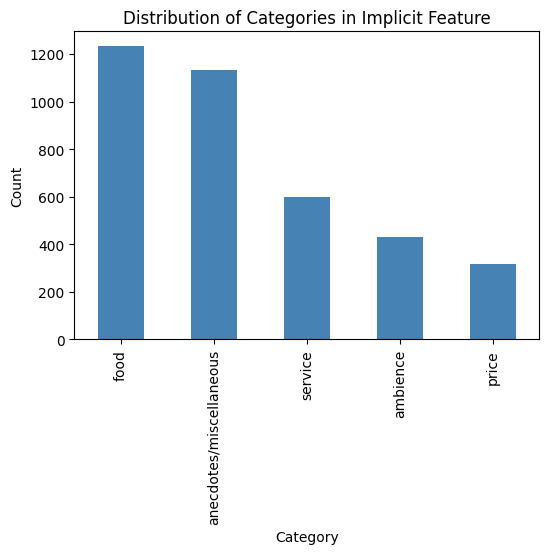

In [14]:


plt.figure(figsize=(6, 4))
df_csv['Implicit Feature'].explode().value_counts().plot(kind='bar', color='steelblue')
plt.title('Distribution of Categories in Implicit Feature')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


# 3. Data Preprocessing

In [15]:

# Preprocesses text for sentiment analysis using NLTK.
def preprocess_comment(text, lowercase=True, remove_punctuation=True,
                   remove_stopwords=True, tokenize=True, sentence_tokenize=False,
                   stem=False, lemmatize=False):

    if lowercase:
        text = text.lower()

    if remove_punctuation:
        # Use string.punctuation for efficiency
        text = text.translate(str.maketrans('', '', string.punctuation))

    if remove_stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
        text = ' '.join([word for word in text.split() if word not in stopwords])

    if tokenize:
        if sentence_tokenize:
            # Use sentence_tokenize for finer control
            sentences = nltk.sent_tokenize(text)
            # Optionally apply preprocessing to each sentence
            preprocessed_sentences = [preprocess_comment(sentence) for sentence in sentences]
            return preprocessed_sentences
        else:
            text = nltk.word_tokenize(text)

# Rules-based approach that chops off suffixes from words based on predefined rules.
    if stem:
        stemmer = PorterStemmer()
        if isinstance(text, list):
            text = [stemmer.stem(word) for word in text]
        else:
            text = stemmer.stem(text)

# Uses dictionaries and linguistic information to map inflections of a word to its base form, called the lemma.
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        if isinstance(text, list):
            text = [lemmatizer.lemmatize(word) for word in text]
        else:
            text = lemmatizer.lemmatize(text)

    return text

In [16]:
df_csv['Preprocessed Sentence'] = df_csv['Sentence'].apply(lambda text : preprocess_comment(text, tokenize=False))

In [17]:
df_csv['Preprocessed Sentence']

0                                       staff horrible us
1       completely fair redeeming factor food average ...
2       food uniformly exceptional capable kitchen pro...
3                gabriela personaly greets recommends eat
4                              go dont enjoy say dont get
                              ...                        
3039                                    highly forgivable
3040    appetizers ate dim sum variety foods impossibl...
3041          arrived 600 pm restaurant practically empty
3042    table pot boiling water sunken surface get pla...
3043                         going mid town location next
Name: Preprocessed Sentence, Length: 3044, dtype: object

In [18]:
df_csv['Sentence'][3]

'Where Gabriela personaly greets you and recommends you what to eat.'

In [19]:
df_csv['Preprocessed Sentence'][3]

'gabriela personaly greets recommends eat'

In [20]:
df_csv['Implicit Feature']

0                             [service]
1       [food, anecdotes/miscellaneous]
2                                [food]
3                             [service]
4             [anecdotes/miscellaneous]
                     ...               
3039          [anecdotes/miscellaneous]
3040                             [food]
3041          [anecdotes/miscellaneous]
3042                             [food]
3043          [anecdotes/miscellaneous]
Name: Implicit Feature, Length: 3044, dtype: object

# 4. Prepare Target Variable (y)

In [21]:

multilabel = MultiLabelBinarizer()

features = multilabel.fit_transform(df_csv['Implicit Feature']).astype('float32')
reviews = df_csv['Sentence'].tolist()

In [22]:
features

array([[0., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [23]:


# Define the mapping from categories to numerical labels
feature_mapping = {
    'food': 0,
    'service': 1,
    'price': 2,
    'ambience': 3,
    'anecdotes/miscellaneous': 4
}

# Apply label mapping
df_csv['Implicit Feature vector'] = df_csv['Implicit Feature'].apply(lambda x: [feature_mapping[category] for category in x])

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(df_csv['Implicit Feature vector'].explode()), y=df_csv['Implicit Feature vector'].explode())

# Convert array to dictionary
class_weights_dict = dict(zip(np.unique(df_csv['Implicit Feature vector'].explode()), class_weights))

# Print the calculated class weights as a dictionary
print("Class Weights:")
print(class_weights_dict)


# Apply one-hot encoding
def one_hot_encode(categories, num_unique_categories):
    one_hot_vector = np.zeros(num_unique_categories)
    one_hot_vector[categories] = 1
    return one_hot_vector

num_unique_categories = len(feature_mapping)
df_csv['y vector'] = df_csv['Implicit Feature vector'].apply(lambda x: one_hot_encode(x, num_unique_categories))


Class Weights:
{0: 0.6024330900243309, 1: 1.2442211055276382, 2: 2.328526645768025, 3: 1.7194444444444446, 4: 0.6556045895851721}


# 6. Build and Train the Model + Model Evaluation

In [24]:
def vectorize_text(X_train, X_test):

    vectorizer = TfidfVectorizer(max_features=5000, analyzer='word', ngram_range=(1, 2), stop_words='english')
    # Transform the text data into vectors
    X_train_vector = vectorizer.fit_transform(X_train)
    X_test_vector = vectorizer.transform(X_test)

    return X_train_vector, X_test_vector

In [25]:


def multi_labels_metrics(predictions, labels, threshold=0.3):
    # Convert raw predictions to binary predictions using the threshold
    binary_predictions = (predictions >= threshold).astype(int)

    f1 = f1_score(labels, binary_predictions, average='macro')
    roc_auc = roc_auc_score(labels, binary_predictions, average='macro')
    hamming = hamming_loss(labels, binary_predictions)

    metrics = {
        "roc_auc": roc_auc,
        "hamming_loss": hamming,
        "f1": f1
    }

    return metrics

def evaluate_multi_label_classifier(predictions, y_test, threshold=0.5):
    # Evaluate metrics
    metrics = multi_labels_metrics(predictions, y_test, threshold)

    return metrics

def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type):
    if model_type == 'logistic_regression':
        model =  MultiOutputClassifier(LogisticRegression(solver='liblinear', class_weight='balanced', C=0.1))
    elif model_type == 'svm':
      svm_classifier = SVC(kernel='linear', probability=True, class_weight='balanced', C=0.1)
      model = MultiOutputClassifier(svm_classifier)



    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    report = evaluate_multi_label_classifier(y_pred, y_test)
    # report = classification_report(y_test, y_pred)

    return report, model


In [26]:
# Load your annotated dataset
df = df_csv

# Split the data into features (X) and labels (y)
X = df_csv['Preprocessed Sentence']
y = df['y vector']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_array = np.vstack(y_train)
y_test_array = np.vstack(y_test)

# Get vector representations
vectorizer = TfidfVectorizer(max_features=5000, analyzer='word', ngram_range=(1, 2), stop_words='english')
# Transform the text data into vectors
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

# Define model types
model_types = ['logistic_regression', 'svm']
trained_models = {}
# Initialize metrics_dict with empty dictionaries for each metric
metrics_dict = {
    'roc_auc': {},
    'hamming_loss': {},
    'f1': {}
}
for model_type in model_types:
    print(f"\nTraining and evaluating using {model_type}:")
    # Train and evaluate the model
    report, trained_model = train_and_evaluate_model(X_train_vector, y_train_array, X_test_vector, y_test_array, model_type)

    # Store the trained model in the dictionary
    trained_models[model_type] = trained_model
    metrics_dict['roc_auc'][model_type] = report['roc_auc']
    metrics_dict['hamming_loss'][model_type] = report['hamming_loss']
    metrics_dict['f1'][model_type] = report['f1']
    # Print results
    print(f"Accuracy for {model_type}: {report}")



Training and evaluating using logistic_regression:
Accuracy for logistic_regression: {'roc_auc': 0.829961132457821, 'hamming_loss': 0.11691297208538588, 'f1': 0.7450552359981227}

Training and evaluating using svm:
Accuracy for svm: {'roc_auc': 0.7970091102826701, 'hamming_loss': 0.1277504105090312, 'f1': 0.7244178915352568}


In [27]:
metrics_dict

{'roc_auc': {'logistic_regression': 0.829961132457821,
  'svm': 0.7970091102826701},
 'hamming_loss': {'logistic_regression': 0.11691297208538588,
  'svm': 0.1277504105090312},
 'f1': {'logistic_regression': 0.7450552359981227, 'svm': 0.7244178915352568}}

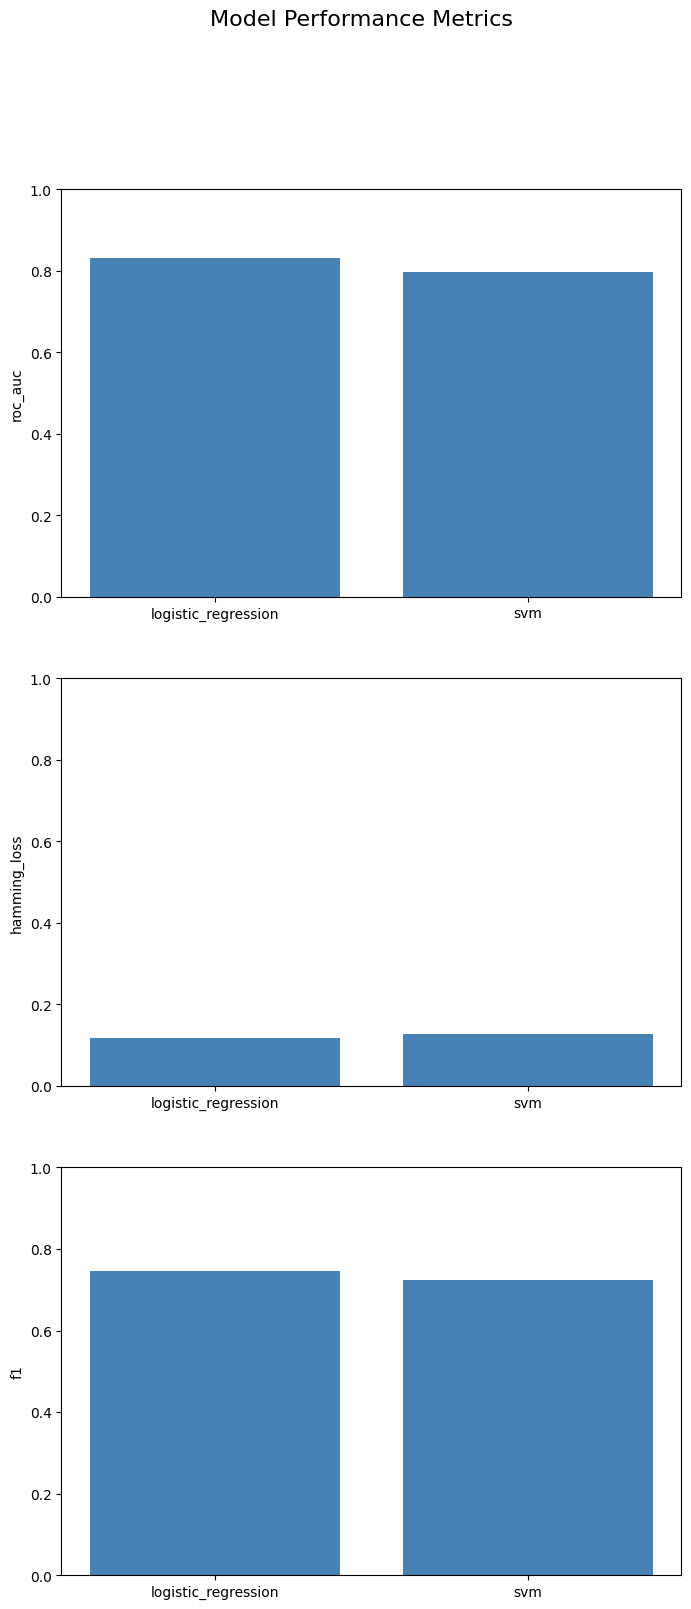

In [28]:

def plot_metrics(metrics_dict, experiment_names):
    metrics_names = list(metrics_dict.keys())
    num_metrics = len(metrics_names)
    num_experiments = len(experiment_names)

    # Create a bar chart for each metric
    fig, ax = plt.subplots(num_metrics, 1, figsize=(8, 6*num_metrics))
    fig.suptitle('Model Performance Metrics', fontsize=16)

    for i, metric_name in enumerate(metrics_names):
        ax[i].bar(experiment_names, [metrics_dict[metric_name][exp] for exp in experiment_names], color='steelblue')
        ax[i].set_ylabel(metric_name)
        ax[i].set_ylim(0, 1)  # Adjust the y-axis limits if needed

    plt.show()


plot_metrics(metrics_dict, model_types)


In [29]:
def plot_metrics(metrics_dict, experiment_names):
    metrics_names = list(metrics_dict.keys())
    num_metrics = len(metrics_names)
    num_experiments = len(experiment_names)

    # Create a grouped bar chart
    fig, ax = plt.subplots(figsize=(8, 8))
    bar_width = 0.1
    index = np.arange(num_experiments)
    opacity = 0.5

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Colors for different experiments

    for i, metric_name in enumerate(metrics_names):
        metrics_values = [metrics_dict[metric_name][exp] for exp in experiment_names]
        ax.bar(index + i * bar_width, metrics_values, bar_width, alpha=opacity, label=metric_name, color=colors[i])

    ax.set_xlabel('Model Types')
    ax.set_ylabel('Metrics')
    ax.set_title('Model Performance Metrics')
    ax.set_xticks(index)
    ax.set_xticklabels(experiment_names)
    ax.legend()

    plt.tight_layout()
    plt.show()

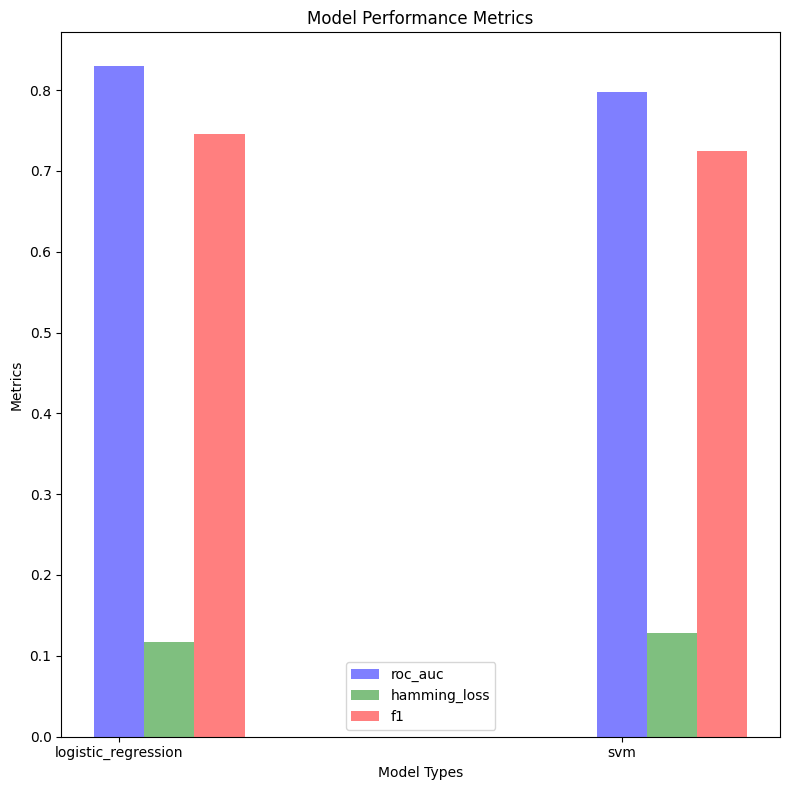

In [30]:
plot_metrics(metrics_dict, model_types)

In [31]:
# use the trained models for making predictions on different review sentences
review_sentences = ["This restaurant has amazing food and great service, as well as high price",
                    "This place is cozy and inviting, but the food is mediocre",
                    "Lively area",
                    "staff is horrible",
                    "The flavors of the dishes were exceptional, but the prices were a bit steep, then surrounding area of hotel is"]

In [32]:
for model_type, _model in trained_models.items():
    print(f"\nPredictions using {model_type}:")
    # Transform the review sentences into vectors using the existing vectorizer
    review_vectors = vectorizer.transform(review_sentences)

    # Make predictions
    pred = _model.predict(review_vectors)

    # Print results
    for i, review_sentence in enumerate(review_sentences):
        print(f"\nReview: {review_sentence}")
        print(f"Prediction: {pred[i]}")

        # Assuming pred is the prediction vector
        for index, probability in enumerate(pred[i]):
            if probability > 0:
                category_name = [key for key, value in feature_mapping.items() if value == index][0]
                print(f"Predicted Category: {category_name}")



Predictions using logistic_regression:

Review: This restaurant has amazing food and great service, as well as high price
Prediction: [1. 1. 1. 0. 0.]
Predicted Category: food
Predicted Category: service
Predicted Category: price

Review: This place is cozy and inviting, but the food is mediocre
Prediction: [1. 0. 0. 1. 0.]
Predicted Category: food
Predicted Category: ambience

Review: Lively area
Prediction: [0. 0. 0. 0. 1.]
Predicted Category: anecdotes/miscellaneous

Review: staff is horrible
Prediction: [0. 1. 0. 0. 0.]
Predicted Category: service

Review: The flavors of the dishes were exceptional, but the prices were a bit steep, then surrounding area of hotel is
Prediction: [1. 0. 1. 0. 0.]
Predicted Category: food
Predicted Category: price

Predictions using svm:

Review: This restaurant has amazing food and great service, as well as high price
Prediction: [1. 1. 1. 0. 0.]
Predicted Category: food
Predicted Category: service
Predicted Category: price

Review: This place is coz